In [20]:
include("F_calculations.jl");

In [3]:
# We can take normchoice to be SNRnorm, SNRnorm_low, or SNRnorm_high
function DSNB_integrand(E, z0, z, i, nubar, ordering, bh_frac, normchoice)
    c0 = 3e8 # m s^(-1)
    if bh_frac == "21"
        return 0.00208 * (c0*normchoice*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z)/(1+z0), i, "small", ordering, nubar) 
        + (ηAD(22, 15)+ηAD(27, 25))*Fmass(E*(1+z)/(1+z0), i, "large", ordering, nubar) + (ηAD(25, 22)+ηAD(125, 27))*Fmass(E*(1+z)/(1+z0), i, "bh", ordering, nubar))
    elseif bh_frac == "41"
        return 0.00208 * (c0*normchoice*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z)/(1+z0), i, "small", ordering, nubar) 
        + ηAD(125, 15)*Fmass(E*(1+z)/(1+z0), i, "bh", ordering, nubar))
    elseif bh_frac == "09"
        return 0.00208 * (c0*normchoice*SFR(z)/Hubble(z)) * (ηAD(15, 8)*Fmass(E*(1+z)/(1+z0), i, "small", ordering, nubar)
        + ηAD(40, 15)*Fmass(E*(1+z)/(1+z0), i, "large", ordering, nubar) + ηAD(125, 40)*Fmass(E*(1+z)/(1+z0), i, "bh", ordering, nubar))
    else
        return 0
    end
end

# Mass method
DSNB(E, z0, i, nubar, ordering, bh_frac, normchoice) = 1/(1+z0) * quadgk(z -> DSNB_integrand(E, z0, z, i, nubar, ordering, bh_frac, normchoice), z0, 5, rtol=1e-2)[1]

# νe method
function DSNB(E, z0, nubar, ordering, bh_frac, normchoice)
    ν1 = DSNB(E, z0, 1, nubar, ordering, bh_frac, normchoice)
    ν2 = DSNB(E, z0, 2, nubar, ordering, bh_frac, normchoice)
    ν3 = DSNB(E, z0, 3, nubar, ordering, bh_frac, normchoice)
    return Usqred(ordering)[1, 1]*ν1 + Usqred(ordering)[1, 2]*ν2 + Usqred(ordering)[1, 3]*ν3
end


# Separating the progenitors: 1pc ≡ one progenitor contribution

function DSNB_integrand_1pc(E, z0, z, i, nubar, ordering, sm, normchoice)
    c0 = 3e8 # m s^(-1)
    # Adding in this integrated mass function so we can multiply by bh fractions at the end
    return 0.00208 * ηAD(125, 8) * (c0*normchoice*SFR(z)/Hubble(z)) * Fmass(E*(1+z)/(1+z0), i, sm, ordering, nubar)
end

DSNB_1pc(E, z0, i, nubar, ordering, sm, normchoice) = 1/(1+z0) * quadgk(z -> DSNB_integrand_1pc(E, z0, z, i, nubar, ordering, sm, normchoice), z0, 5, rtol=1e-2)[1]

function DSNB_1pc(E, z0, nubar, ordering, sm, normchoice)
    ν1 = DSNB_1pc(E, z0, 1, nubar, ordering, sm, normchoice)
    ν2 = DSNB_1pc(E, z0, 2, nubar, ordering, sm, normchoice)
    ν3 = DSNB_1pc(E, z0, 3, nubar, ordering, sm, normchoice)
    return Usqred(ordering)[1, 1]*ν1 + Usqred(ordering)[1, 2]*ν2 + Usqred(ordering)[1, 3]*ν3
end;


# Define this effective length function
LeffIntegrand(z) = (H0*sqrt(energy_matter*(1+z)^3 + energy_dark))^(-1)*(1+z)^(-2)

leff_quadint(z0) = quadgk(z -> LeffIntegrand(z), 0, z0)[1]

zs_leff = range(0, 5, 1000)
leff_ne = Interpolations.interpolate((vec(zs_leff),), leff_quadint.(zs_leff), Gridded(Linear()))
lefftrue = extrapolate(leff_ne, 0.0)

# Approximating with a 14 degree polynomial

# Procedure for fitting the polynomial
#=
xsvec = range(0, 5, 100)
leffsvec = 70*leff.(xsvec)

p = Polynomials.fit(xsvec, leffsvec, 14)
=#

function leff(x) 
    if x == 0.0
        return 0.0
    else
        (3.844126829887412e-6 + 0.9994711237154343*x - 1.2171757160998375*x^2 + 1.2011732904692138*x^3 - 1.0258795580085436*x^4 + 0.7535135022231549*x^5 - 0.4576091931617817*x^6 + 0.2207326320476638*x^7 - 0.0820545498767346*x^8 + 0.022953521018636694*x^9 - 0.004712524469463747*x^(10) + 0.0006858791896371295*x^(11) - 6.682066367256103e-5*x^(12) + 3.9015397017829775e-6*x^(13) - 1.0310563080271216e-7*x^(14))/70
    end
end

# Decay function 
function decay(E, α, z0, z)
    scalefactor = 4.68e28
    return exp(-scalefactor*α*(leff(z) - leff(z0))*(1+z0)/E)
end


# This function returns the redshift point where the decay function has attenuated by 
# roughly two orders of magnitude, and if we break the integral bounds at this point the integral might run faster
# with QuadGK.jl
function zcutoff(E, α, z0)
    innerpart = 0.007+(E/(4.68e28*α))*log(0.01*exp(-4.68e28*α*leff(z0)/E))
    if innerpart > 0.0
        return -0.555*(log(350*(innerpart))-0.9)
    else
        return 0.0
    end
end;


# Invisible decay implementation

# Mass method
function DSNB_idecay(E, z0, α, i, nubar, ordering, bh_frac, normchoice)
    zcut = zcutoff(E, α, z0)
    if zcut > z0 && zcut < 5 && decay(E, α, z0, zcut) < 0.1
        return quadgk(z -> 1/(1+z0) * DSNB_integrand(E, z0, z, i, nubar, ordering, bh_frac, normchoice)*decay(E, α, z0, z), z0, zcut, 5, rtol=1e-2)[1]
    else
        return quadgk(z -> 1/(1+z0) * DSNB_integrand(E, z0, z, i, nubar, ordering, bh_frac, normchoice)*decay(E, α, z0, z), z0, 5, rtol=1e-2)[1]
    end
end

# νe method
function DSNB_idecay(E, z0, α1, α2, α3, nubar, ordering, bh_frac, normchoice)
    ν1 = DSNB_idecay(E, z0, α1, 1, nubar, ordering, bh_frac, normchoice)
    ν2 = DSNB_idecay(E, z0, α2, 2, nubar, ordering, bh_frac, normchoice)
    ν3 = DSNB_idecay(E, z0, α3, 3, nubar, ordering, bh_frac, normchoice)
    return Usqred(ordering)[1, 1]*ν1 + Usqred(ordering)[1, 2]*ν2 + Usqred(ordering)[1, 3]*ν3
end

# Single progenitor versions
function DSNB_idecay_1pc(E, z0, α, i, nubar, ordering, sm, normchoice)
    zcut = zcutoff(E, α, z0)
    if zcut > z0 && zcut < 5 && decay(E, α, z0, zcut) < 0.1
        return quadgk(z -> 1/(1+z0) * DSNB_integrand_1pc(E, z0, z, i, nubar, ordering, sm, normchoice)*decay(E, α, z0, z), z0, zcut, 5, rtol=1e-2)[1]
    else
        return quadgk(z -> 1/(1+z0) * DSNB_integrand_1pc(E, z0, z, i, nubar, ordering, sm, normchoice)*decay(E, α, z0, z), z0, 5, rtol=1e-2)[1]
    end
end

function DSNB_idecay_1pc(E, z0, α1, α2, α3, nubar, ordering, sm, normchoice)
    ν1 = DSNB_idecay_1pc(E, z0, α1, 1, nubar, ordering, sm, normchoice)
    ν2 = DSNB_idecay_1pc(E, z0, α2, 2, nubar, ordering, sm, normchoice)
    ν3 = DSNB_idecay_1pc(E, z0, α3, 3, nubar, ordering, sm, normchoice)
    return Usqred(ordering)[1, 1]*ν1 + Usqred(ordering)[1, 2]*ν2 + Usqred(ordering)[1, 3]*ν3
end;

In [7]:
DSNB_idecay(1, 0, 10^(-24), 0.0, 0.0, true, "NO", "21", SNRnorm)

0.2317518252709942

In [12]:
# Detector stuff now

# Energy resolution
function δ(Ee, experiment, channel)
    if experiment == "HK"
        if channel == "IBD"
            return 0.1*sqrt(Ee)
        elseif channel == "ES"
            return 0.0349*Ee + 0.376*sqrt(Ee) - 0.123
        else
            return println("error")
        end
    else
        return println("error")
    end
end

ϵIBD = 0.67
NtIBD = 2.5e34
Δ = mass_neutron - mass_proton

# Response function
K(u, v, experiment, channel) = (1/(δ(v, experiment, channel)*sqrt(2*π)))*exp(-((u-v)/(δ(v, experiment, channel)*sqrt(2)))^2)
σIBD(Eν) = 10^(-43) * sqrt((Eν - Δ)^2 - mass_e^2)*(Eν - Δ)*Eν^(-0.07056 + 0.02018*log(Eν) - 0.001953*(log(Eν)^3))

function expnew(x)
    if exp(x) == Inf
        return 1e30
    else
        return exp(x)
    end
end

# Antiderivative wrt v (which is e_reco)
antiKIBD(u, v) = 0.5*(1 - erf((5*sqrt(2)*(u-v))/sqrt(v)) + expnew(200*u)*(erf((5*sqrt(2)*(u+v))/sqrt(v)) - 1))

binint_KIBD(Eetrue, Eereco_min, Eereco_max) = antiKIBD(Eetrue, Eereco_max) - antiKIBD(Eetrue, Eereco_min)


# Just focusing on ν3 decay rn
function diff_event_rate_IBD_idecay(Ee, α1, α2, α3, ordering, bh_frac, normchoice)
    Eν = Ee + Δ
    if α1 == 0.0 && α2 == 0.0 && α3 == 0.0
        return ϵIBD * NtIBD * σIBD(Eν) * DSNB(Eν, 0, true, ordering, bh_frac, normchoice)
    else
        return ϵIBD * NtIBD * σIBD(Eν) * DSNB_idecay(Eν, 0, α1, α2, α3, true, ordering, bh_frac, normchoice)
 #   elseif decay == "visible"
 #       return ϵIBD * NtIBD * σIBD(Eν) * DSNB_vdecay_νe(Eν, α, daughter, true, ordering, bh_frac, normchoice)
    end
end

#=
function diff_event_rate_IBD_alt(Ee, α, ordering, bh_frac, normchoice)
    Eν = Ee + Δ
    return ϵIBD * NtIBD * σIBD(Eν) * DSNB_vdecay_νe_alt(Eν, α, true, ordering, bh_frac, normchoice)
end
=#

# event_rate_IBD_noeres(Ee_min, Ee_max) = 525600 * 60 * 20 * quadgk(Ee -> diff_event_rate_IBD(Ee), Ee_min, Ee_max)[1]

function event_rate_IBD_idecay(Ee_min, Ee_max, α1, α2, α3, ordering, bh_frac, normchoice, yrs)
    min_etrue, max_etrue = maximum([0, (Ee_min - 4*0.1*sqrt(Ee_min))]), Ee_max + 4*0.1*sqrt(Ee_max)
    return 525600 * 60 * yrs * quadgk(Eetrue -> diff_event_rate_IBD_idecay(Eetrue, α1, α2, α3, ordering, bh_frac, normchoice)*binint_KIBD(Eetrue, Ee_min, Ee_max), min_etrue, max_etrue, rtol=1e-3)[1]
end;
#=
function event_rate_IBD_alt(Ee_min, Ee_max, α, ordering, bh_frac, normchoice)
    min_etrue, max_etrue = maximum([0, (Ee_min - 4*0.1*sqrt(Ee_min))]), Ee_max + 4*0.1*sqrt(Ee_max)
    return 525600 * 60 * 20 * quadgk(Eetrue -> diff_event_rate_IBD_alt(Eetrue, α, ordering, bh_frac, normchoice)*binint_KIBD(Eetrue, Ee_min, Ee_max), min_etrue, max_etrue, rtol=1e-3)[1]
end;
=#

In [29]:
emins = 12:2:32
emaxes = 14:2:34

dsnb_hk_nodecay = event_rate_IBD_idecay.(emins, emaxes, 0.0, 0.0, 0.0, "NO", "21", SNRnorm, 20)
dsnb_hk_idecay_24_0_0 = event_rate_IBD_idecay.(emins, emaxes, 10^(-24), 0.0, 0.0, "NO", "21", SNRnorm, 20)
dsnb_hk_idecay_0_24_0 = event_rate_IBD_idecay.(emins, emaxes, 0.0, 10^(-24), 0.0, "NO", "21", SNRnorm, 20);

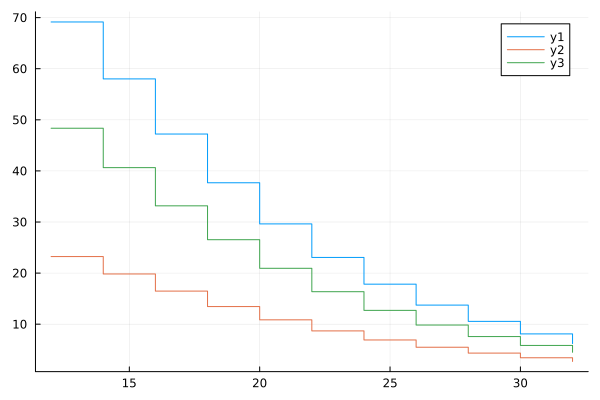

In [30]:
plot(
    emins,
    [dsnb_hk_nodecay dsnb_hk_idecay_24_0_0 dsnb_hk_idecay_0_24_0],
    seriestype=:step,
)